In [1]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')
import numpy as np

%config InlineBackend.figure_format = 'retina'

In [2]:
# Accessing all data files for teleportation

# Establishing the path for each file
folder = '../../teleportation/'
path_tel_sim = folder + 'teleportation_results_simulator.txt'
path_tel_sim_det = folder + 'teleportation_results_simulator_detailed.txt'
path_tel_noise = folder + 'teleportation_results_noise.txt'
path_tel_noise_det = folder + 'teleportation_results_noise_detailed.txt'

# Storing all data as local variables
simulator = pd.read_csv(path_tel_sim, sep=',', dtype=str)
simulator_detailed = pd.read_csv(path_tel_sim_det, sep=',', dtype=str)
noise = pd.read_csv(path_tel_noise, sep=',', dtype=str)
noise_detailed = pd.read_csv(path_tel_noise_det, sep=',', dtype=str)

In [3]:
data_simulator = simulator_detailed
data_noise = noise_detailed

In [4]:
# Function to add labels on top of the bars
def add_value_labels(bars):
    for bar in bars:
        height = bar.get_height()
        plt.annotate(f'{height:.0f}',
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3),  # 3 points vertical offset
                     textcoords="offset points",
                     ha='center', va='bottom')

def generate_plot(qubits, initial_state, beta_state, simulator=data_simulator, noise=data_noise, save_fig=False, figname=None):
    M = qubits
    initial = initial_state
    beta = beta_state

    dpi = 400
    
    sim_data = data_simulator[(data_simulator['Qubits'] == M) & (data_simulator['Initial State'] == initial) & (data_simulator['Beta State'] == beta)]
    noi_data = data_noise[(data_noise['Qubits'] == M) & (data_noise['Initial State'] == initial) & (data_noise['Beta State'] == beta)]

    # Merge the datasets on 'Measurement Result' with an outer join to include all unique labels
    merged_data = pd.merge(sim_data, noi_data, on='Measurement Result', how='outer', suffixes=('_sim', '_noi'))

    # Replace NaN values with 0 to ensure all bars can be plotted
    merged_data.fillna(0, inplace=True)

    # Sort the merged data to have a consistent order for x-ticks
    merged_data.sort_values('Measurement Result', inplace=True)

    # Ensure 'Frequency' columns are treated as floats
    merged_data['Frequency_sim'] = merged_data['Frequency_sim'].astype(float)
    merged_data['Frequency_noi'] = merged_data['Frequency_noi'].astype(float)

    # Create the figure with a higher resolution
    fig, ax = plt.subplots(figsize=(12, 6), dpi=dpi)  # Increase DPI for better resolution

    # Width of the bars
    bar_width = 0.35
    
    # Generate index for the x-axis
    index = np.arange(len(merged_data['Measurement Result'])) 

    # Optionally, adjust the x-axis limits if needed
    ax.set_xlim(min(index)-bar_width, max(index)+bar_width*2)

    # Create the bar plots
    bars_sim = ax.bar(index, merged_data['Frequency_sim'], bar_width, color='skyblue', label='AerSimulator')
    bars_noi = ax.bar(index + bar_width, merged_data['Frequency_noi'], bar_width, color='tomato', label='Noisy Simulator')

    # Add labels, title, and ticks
    ax.set_xlabel('Measurement Outcome')
    ax.set_ylabel('Counts')
    ax.set_title(fr'Histogram of Measurements for {qubits} Qubits, Initial State $\left|{initial_state}\right>$, Beta State $\left|{beta_state}\right>$')
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(merged_data['Measurement Result'].astype(str), rotation=45)

    # Call the function to add labels on top of the bars
    add_value_labels(bars_sim)
    add_value_labels(bars_noi)

    # Add a legend
    ax.legend()

    # Optionally save the figure in high resolution
    if save_fig and figname:
        fig.savefig(figname, dpi=dpi, format='png')  # You can change format to 'pdf', 'svg', or 'eps' for vector formats
        print(f"Wrote figure to {figname}")

    # Return the figure object
    return fig

In [5]:
# %%capture
# Fig = generate_plot('2', '0', '00', save_fig=True, figname='figures/simulator-vs-noise.png')

In [6]:
def calculate_error_rate(qubits=None, initial_state=None, beta_state=None, simulator=data_simulator, noise=data_noise):
    # Apply filters based on the function parameters
    simulator_filter = (True if qubits is None else simulator['Qubits'] == qubits) & \
                       (True if initial_state is None else simulator['Initial State'] == initial_state) & \
                       (True if beta_state is None else simulator['Beta State'] == beta_state)
    
    noise_filter = (True if qubits is None else noise['Qubits'] == qubits) & \
                   (True if initial_state is None else noise['Initial State'] == initial_state) & \
                   (True if beta_state is None else noise['Beta State'] == beta_state)
    
    sim_data = simulator[simulator_filter]
    noi_data = noise[noise_filter]

    simulator_measurements = set(sim_data['Measurement Result'])
    noise_measurements = set(noi_data['Measurement Result'])

    error_measurements = noise_measurements - simulator_measurements
    
    noi_data.loc[:, 'Frequency'] = noi_data['Frequency'].astype(int)
    error_frequency = noi_data[noi_data['Measurement Result'].isin(error_measurements)]['Frequency'].sum()
    total_noise_frequency = noi_data['Frequency'].sum()

    if total_noise_frequency > 0:
        error_rate = error_frequency / total_noise_frequency
    else:
        error_rate = 0  # Avoid division by zero

    return error_rate

In [7]:
qubits = [str(i) for i in range(2, 14)]
initial_states = ['0', '1']
beta_states = ['00', '10', '01', '11']

error_data = []

# Loop through each combination of qubits, initial states, and beta states
for q in qubits:
    for initial in initial_states:
        for beta in beta_states:
            error_rate = calculate_error_rate(q, initial, beta)
            error_data.append({
                'Qubits': q,
                'Initial State': initial,
                'Beta State': beta,
                'Error Rate': error_rate
            })

# Convert the list to a DataFrame
error_df = pd.DataFrame(error_data)

In [8]:
print(error_df)

   Qubits Initial State Beta State  Error Rate
0       2             0         00       0.044
1       2             0         10       0.039
2       2             0         01       0.048
3       2             0         11       0.048
4       2             1         00       0.043
..    ...           ...        ...         ...
91     13             0         11       0.501
92     13             1         00       0.473
93     13             1         10       0.486
94     13             1         01       0.457
95     13             1         11       0.494

[96 rows x 4 columns]


In [9]:
# Calculate the average error rate for each number of qubits
error_rates_qubits = []
for q in qubits:
    qubit_data = error_df[error_df['Qubits'] == q]
    average_error = qubit_data['Error Rate'].mean()
    error_rates_qubits.append(average_error)

In [10]:
def plot_error_rates_qubits(error_rates, qubit_range, save_fig=False, figname=None):
    dpi = 400  # Set the resolution for the plot
    fig, ax = plt.subplots(figsize=(10, 6), dpi=dpi)
    
    ax.plot(qubit_range, error_rates, marker='o', linestyle='-', color='tomato')

    # Adding title and labels
    ax.set_title('Error Rate as a Function of Qubits')
    ax.set_xlabel('Number of Qubits in Entangled State')
    ax.set_ylabel('Error Rate')
    ax.set_xticks(np.arange(len(qubit_range)))  # Ensure that all qubit counts are shown as ticks
    ax.set_xticklabels(qubit_range)

    # Display grid
    ax.grid(True)

    # Optionally save the figure in high resolution
    if save_fig and figname:
        fig.savefig(figname, dpi=dpi, format='png')  # Can change format to 'pdf', 'svg', 'eps' for vector formats
        print(f"Wrote high-resolution figure to {figname}")

    # Show plot if not saving (or also show if desired)
    if not save_fig or (save_fig and figname is None):
        plt.show()
    
    # Return the figure object
    return fig

In [11]:
%%capture
# Fig = plot_error_rates_qubits(error_rates_qubits, qubits, save_fig=True, figname='figures/error-rate-qubits-all.png')

In [12]:
# Calculate the average error rate for each initial state
error_rates_initial = []
for initial in initial_states:
    initial_data = error_df[error_df['Initial State'] == initial]
    average_error = initial_data['Error Rate'].mean()
    error_rates_initial.append(average_error)

In [13]:
# Calculate the average error rate for each beta state
error_rates_beta = []
for beta in beta_states:
    beta_data = error_df[error_df['Beta State'] == beta]
    average_error = beta_data['Error Rate'].mean()
    error_rates_beta.append(average_error)

In [14]:
def plot_error_rates_histogram(error_rates, labels, title, xlabel, ylabel='Error Rate', save_fig=False, figname=None):
    dpi = 400  # High resolution for the plot
    fig, ax = plt.subplots(figsize=(8, 6), dpi=dpi)

    # Create the histogram
    bars = ax.bar(labels, error_rates, color='skyblue')

    # Adding title and labels
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xticks(range(len(labels)))  # Set x-ticks to match the labels
    ax.set_xticklabels(labels)

    # Add value labels to the bars
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 4), va='bottom', ha='center')

    # Optionally save the figure in high resolution
    if save_fig and figname:
        fig.savefig(figname, dpi=dpi, format='png')
        print(f"Wrote high-resolution figure to {figname}")

    # Show plot if not saving (or also show if desired)
    if not save_fig or (save_fig and figname is None):
        plt.show()

    # Return the figure object
    return fig

In [15]:
%%capture

# Usage for initial states
# Fig = plot_error_rates_histogram(
#     error_rates_initial, 
#     initial_states, 
#     title='Error Rate for Each Initial State', 
#     xlabel='Initial State',
#     save_fig=True,
#     figname='figures/error-rate-initial-states.png'
# )

In [16]:
%%capture

# Usage for Beta States
# Fig = plot_error_rates_histogram(
#     error_rates_beta, 
#     beta_states, 
#     title='Error Rate for Each Beta State', 
#     xlabel='Beta State',
#     save_fig=True,
#     figname='figures/error-rate-beta-states.png'
# )

In [17]:
# Initialize a dictionary to hold the error rates for each initial state
error_rates_by_initial_state = {initial: [] for initial in initial_states}

# Calculate the average error rate for each number of qubits for each initial state
for q in qubits:
    for initial in initial_states:
        # Filter data for the current number of qubits and initial state
        qubit_initial_data = error_df[(error_df['Qubits'] == q) & (error_df['Initial State'] == initial)]
        
        # Calculate the average error and append to the correct list in the dictionary
        average_error = qubit_initial_data['Error Rate'].mean()
        error_rates_by_initial_state[initial].append(average_error)

In [18]:
# Initialize a dictionary to hold the error rates for each initial state
error_rates_by_beta_state = {beta: [] for beta in beta_states}

# Calculate the average error rate for each number of qubits for each initial state
for q in qubits:
    for beta in beta_states:
        # Filter data for the current number of qubits and initial state
        qubit_beta_data = error_df[(error_df['Qubits'] == q) & (error_df['Beta State'] == beta)]
        
        # Calculate the average error and append to the correct list in the dictionary
        average_error = qubit_beta_data['Error Rate'].mean()
        error_rates_by_beta_state[beta].append(average_error)

In [19]:
def plot_error_rates(error_rates_dict, qubit_range, title, legend_title, xlabel, ylabel='Error Rate', save_fig=False, figname=None):
    dpi = 400  # Set the resolution for the plot
    fig, ax = plt.subplots(figsize=(10, 6), dpi=dpi)
    
    # Plot each set of error rates with a unique marker and color
    markers = ['o', 's', 'D', '^']  # Example markers
    colors = ['skyblue', 'tomato', 'forestgreen', 'gold']  # Example colors
    
    for (label, error_rates), marker, color in zip(error_rates_dict.items(), markers, colors):
        ax.plot(qubit_range, error_rates, marker=marker, linestyle='-', color=color, label=fr'{legend_title} $\left|{label}\right>$')
    
    # Adding title and labels
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xticks(np.arange(len(qubit_range)))  # Ensure that all qubit counts are shown as ticks
    ax.set_xticklabels(qubit_range)

    # Display grid
    ax.grid(True)
    
    # Add legend
    ax.legend(title=legend_title)

    # Optionally save the figure in high resolution
    if save_fig and figname:
        fig.savefig(figname, dpi=dpi, format='png')  # Can change format to 'pdf', 'svg', 'eps' for vector formats
        print(f"Wrote high-resolution figure to {figname}")

    # Show plot if not saving (or also show if desired)
    if not save_fig or (save_fig and figname is None):
        plt.show()
    
    # Return the figure object
    return fig

In [20]:
%%capture

# Usage for initial states
# Fig = plot_error_rates(
#     error_rates_dict=error_rates_by_initial_state, 
#     qubit_range=qubits, 
#     title='Error Rate as a Function of Qubits for Different Initial States',
#     xlabel='Number of Qubits in Entangled State',
#     legend_title='Initial State',
#     save_fig=True,
#     figname='figures/error-rate-qubits-initial-states.png'
# )

In [21]:
%%capture

# Example usage for beta states
# Fig = plot_error_rates(
#     error_rates_dict=error_rates_by_beta_state, 
#     qubit_range=qubits, 
#     title='Error Rate as a Function of Qubits for Different Beta States',
#     xlabel='Number of Qubits in Entangled State',
#     legend_title='Beta State',
#     save_fig=True,
#     figname='figures/error-rate-qubits-beta-states.png'
# )

In [22]:
# Establishing the path for each file
path_ghz = folder + 'ghz-lima-data.txt'
path_bell = folder + 'bell-lima-data.txt'

# Storing all data as local variables
ghz = pd.read_csv(path_ghz, sep=',', dtype=str)
bell = pd.read_csv(path_bell, sep=',', dtype=str)

In [23]:
# Extracting the 'Measurement' column as a list for labels and 'Frequency' column as a list for counts
ghz_labels = ghz['Measurement'].tolist()
ghz_counts = ghz['Frequency'].astype(int).tolist()  # Convert to int for numerical operations
bell_labels = bell['Measurement'].tolist()
bell_counts = bell['Frequency'].astype(int).tolist()  # Convert to int for numerical operations

In [24]:
ghz_errors = sum(n for n in ghz_counts if n<100)
ghz_total = sum(ghz_counts)
ghz_error_rate = ghz_errors / ghz_total if ghz_total > 0 else 0  # Checking to prevent division by zero

bell_errors = sum(n for n in bell_counts if n<100)
bell_total = sum(bell_counts)
bell_error_rate = bell_errors / bell_total if bell_total > 0 else 0  # Checking to prevent division by zero

In [6]:
def plot_histogram(counts, labels, title, xlabel='Measurement Outcome', ylabel='Counts', error_rate=None, save_fig=False, figname=None):
    dpi = 400  # High resolution for the plot
    fig, ax = plt.subplots(figsize=(8, 6), dpi=dpi)

    # Create the histogram
    bars = ax.bar(labels, counts, color='skyblue')

    # Adding title and labels
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xticks(range(len(labels)))  # Set x-ticks to match the labels
    ax.set_xticklabels(labels, rotation=45)

    # Add value labels to the bars
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 4), va='bottom', ha='center')

    # Display grid
    # ax.grid(axis='y', linestyle='--', alpha=0.7)

    # Add a text box with the error rate
    if error_rate is not None:
        error_text = f'Error rate: {error_rate:.4f}'
        props = dict(boxstyle='round', facecolor='white', alpha=0.5)
        ax.text(0.05, 0.95, error_text, transform=ax.transAxes, fontsize=12,
                verticalalignment='top', bbox=props)

    # Optionally save the figure in high resolution
    if save_fig and figname:
        fig.savefig(figname, dpi=dpi, format='png')
        print(f"Wrote high-resolution figure to {figname}")

    # Show plot if not saving (or also show if desired)
    if not save_fig or (save_fig and figname is None):
        plt.show()

    # Return the figure object
    return fig

In [26]:
# Fig = plot_histogram(
#     ghz_counts,
#     ghz_labels,
#     title=r'Quantum Computer Measurements for 3 Qubits, Initial State $\left|1\right>$, Beta State $\left|00\right>$',
#     error_rate=ghz_error_rate,
#     save_fig=True,
#     figname='figures/lima-ghz-teleportation.png'
# )

# Fig = plot_histogram(
#     bell_counts,
#     bell_labels,
#     title=r'Quantum Computer Measurements for 2 Qubits, Initial State $\left|1\right>$, Beta State $\left|00\right>$',
#     error_rate=bell_error_rate,
#     save_fig=True,
#     figname='figures/lima-bell-teleportation.png'
# )

In [27]:
ghz_sim = data_noise[(data_noise['Qubits'] == '3') & (data_noise['Initial State'] == '1') & (data_noise['Beta State'] == '00')]
bell_sim = data_noise[(data_noise['Qubits'] == '2') & (data_noise['Initial State'] == '1') & (data_noise['Beta State'] == '00')]

In [28]:
ghz_sim_labels = ghz_sim['Measurement Result'].tolist()
ghz_sim_counts = ghz_sim['Frequency'].astype(int).tolist()  # Convert to int for numerical operations

bell_sim_labels = bell_sim['Measurement Result'].tolist()
bell_sim_counts = bell_sim['Frequency'].astype(int).tolist()  # Convert to int for numerical operations

ghz_sim_errors = sum(n for n in ghz_sim_counts if n<100)
ghz_sim_total = sum(ghz_sim_counts)
ghz_sim_error_rate = ghz_sim_errors / ghz_sim_total if ghz_sim_total > 0 else 0  # Checking to prevent division by zero

bell_sim_errors = sum(n for n in bell_sim_counts if n<100)
bell_sim_total = sum(bell_sim_counts)
bell_sim_error_rate = bell_sim_errors / bell_sim_total if bell_sim_total > 0 else 0  # Checking to prevent division by zero

In [29]:
# # Create a dictionary from current labels to their indices
# label_to_index = {label: i for i, label in enumerate(ghz_sim_labels)}

# # Create new lists for the reordered labels and counts
# new_ghz_sim_labels = []
# new_ghz_sim_counts = []

# # Reorder the labels and counts according to the desired order
# for label in ghz_labels:
#     index = label_to_index[label]
#     new_ghz_sim_labels.append(ghz_sim_labels[index])
#     new_ghz_sim_counts.append(ghz_sim_counts[index])

# # The reordered labels and counts
# ghz_sim_labels = new_ghz_sim_labels
# ghz_sim_counts = new_ghz_sim_counts

# Create a dictionary from current labels to their indices
label_to_index = {label: i for i, label in enumerate(bell_sim_labels)}

# Create new lists for the reordered labels and counts
new_bell_sim_labels = []
new_bell_sim_counts = []

# Reorder the labels and counts according to the desired order
for label in bell_labels:
    index = label_to_index[label]
    new_bell_sim_labels.append(bell_sim_labels[index])
    new_bell_sim_counts.append(bell_sim_counts[index])

# The reordered labels and counts
bell_sim_labels = new_bell_sim_labels
bell_sim_counts = new_bell_sim_counts

In [4]:
bell_aer = data_simulator[(data_simulator['Qubits'] == '2') & (data_simulator['Initial State'] == '1') & (data_simulator['Beta State'] == '00')]

In [5]:
bell_aer_labels = bell_aer['Measurement Result'].tolist()
bell_aer_counts = bell_aer['Frequency'].astype(int).tolist()  # Convert to int for numerical operations

Wrote high-resolution figure to figures/simulator-bell-teleportation.png


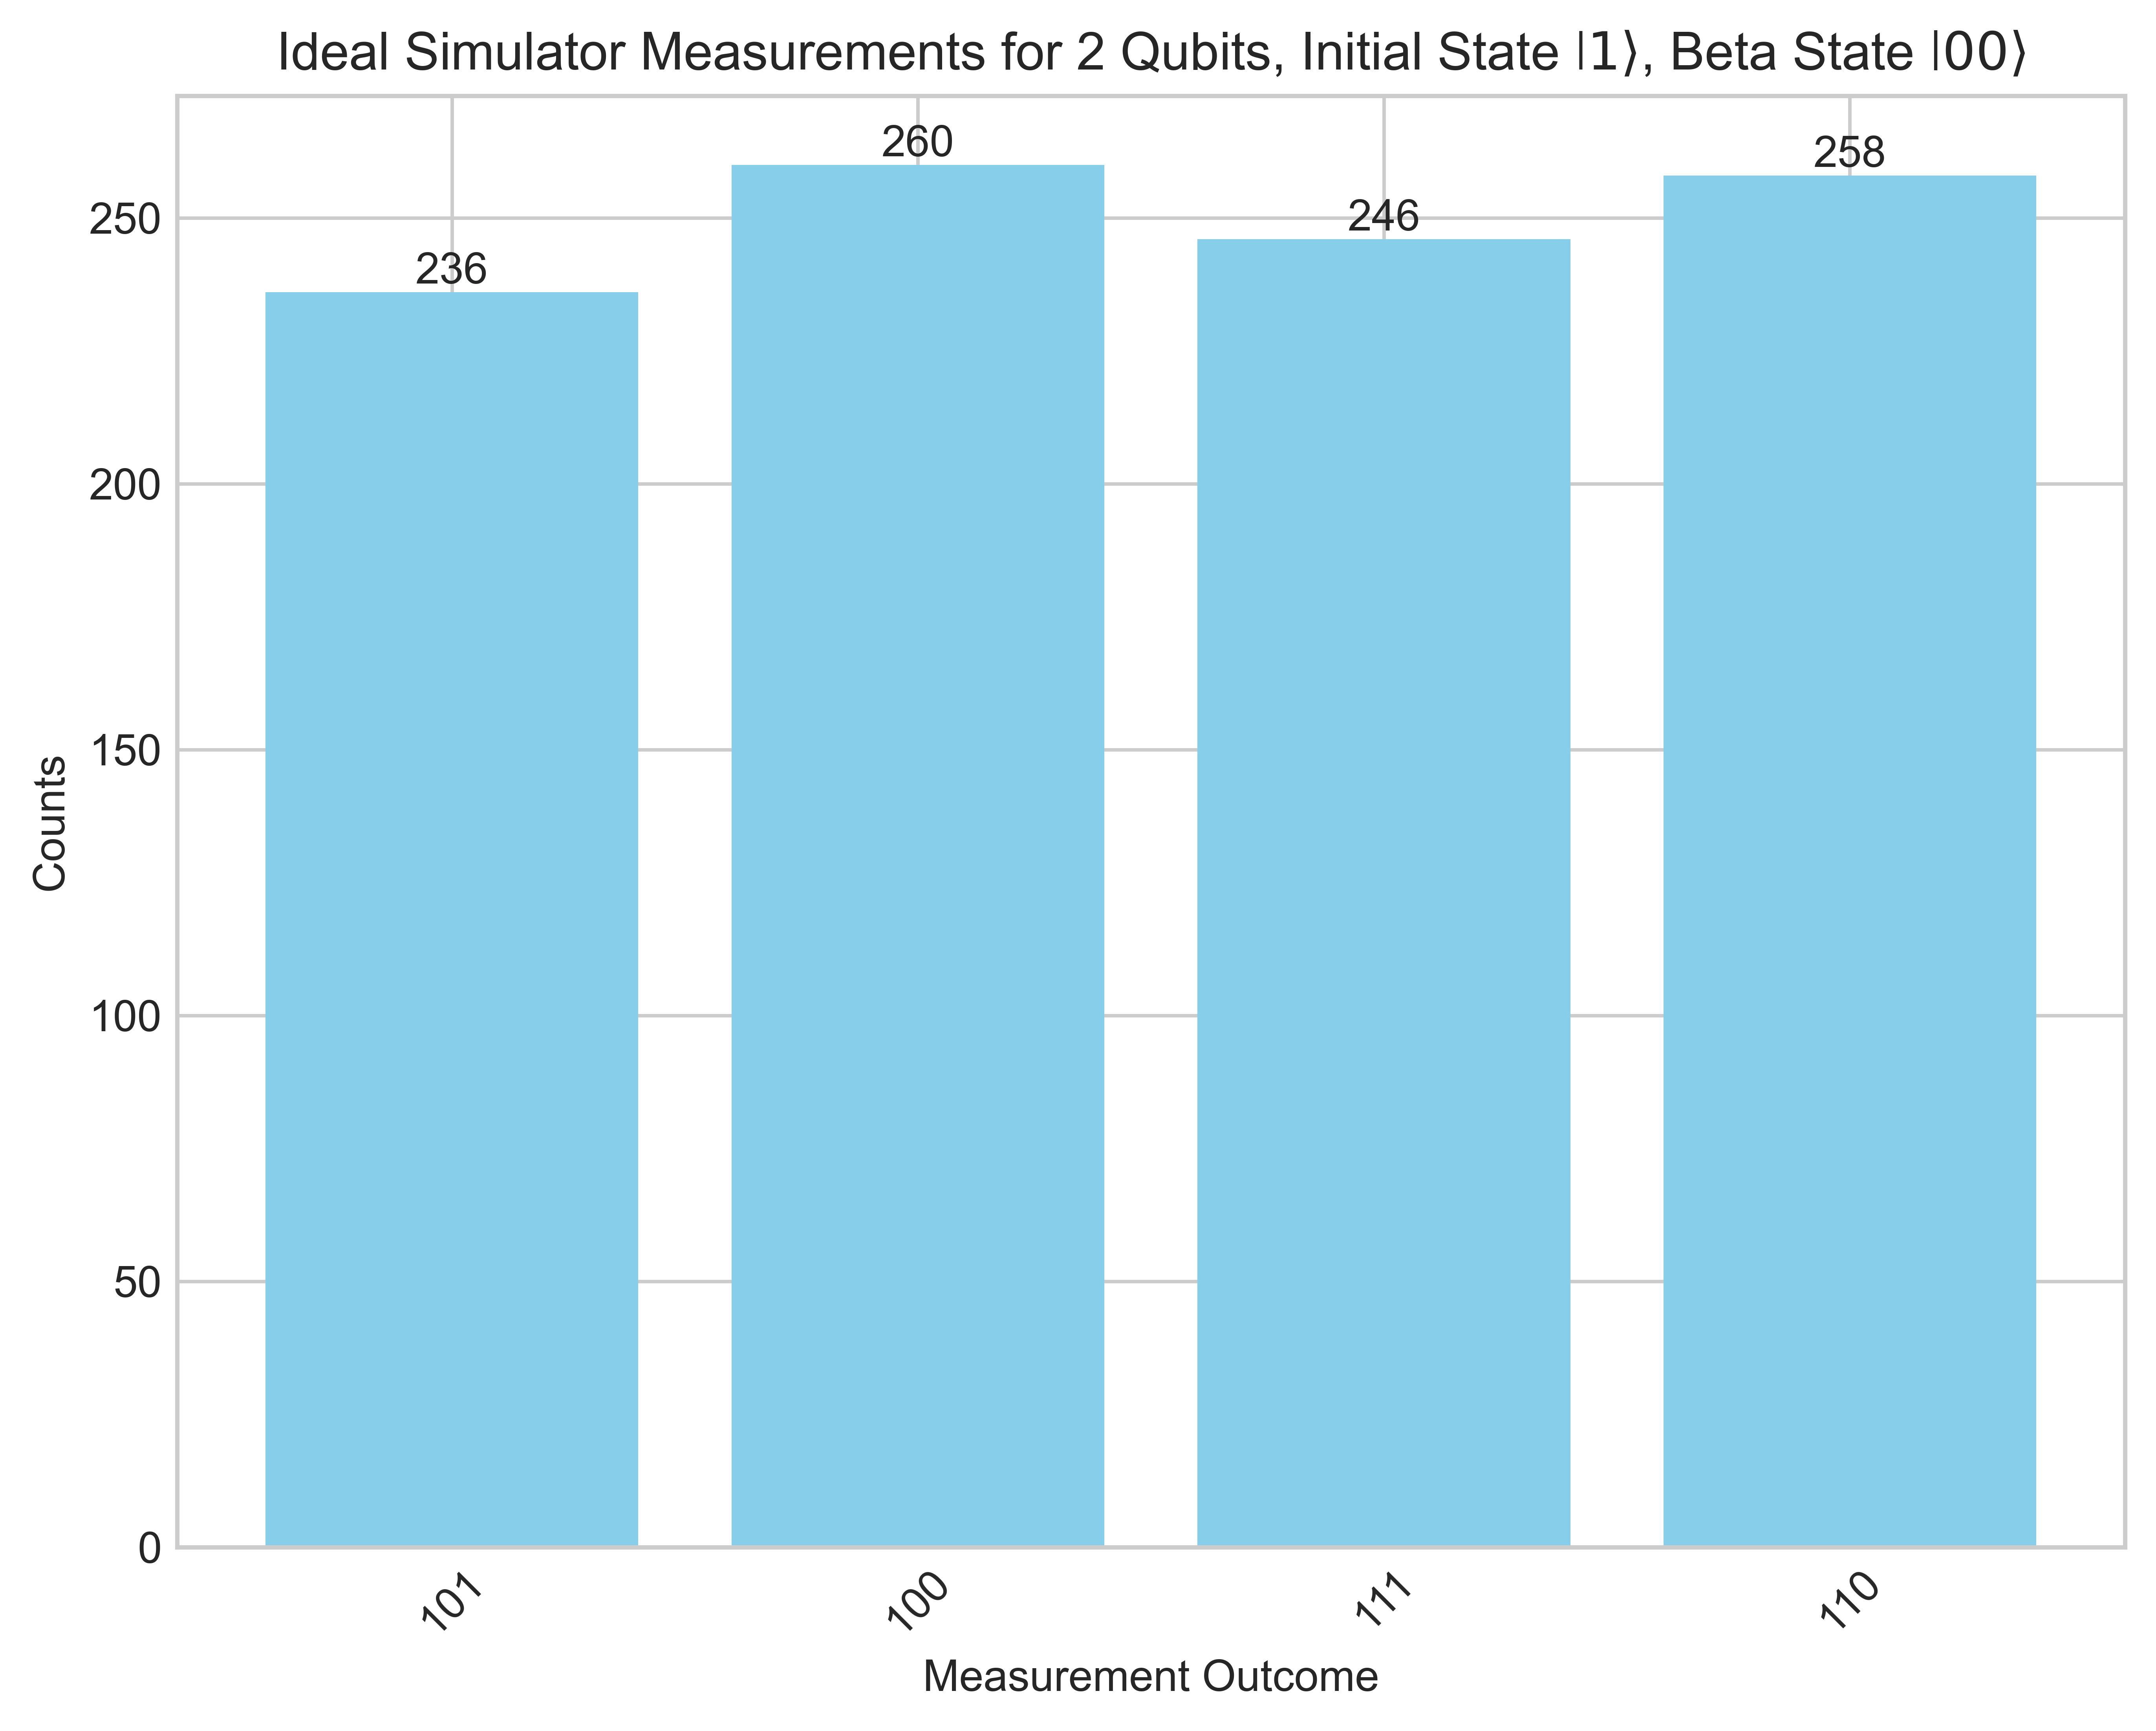

In [7]:
# Fig = plot_histogram(
#     ghz_sim_counts,
#     ghz_sim_labels,
#     title=r'Simulator Measurements for 3 Qubits, Initial State $\left|1\right>$, Beta State $\left|00\right>$',
#     error_rate=ghz_sim_error_rate,
#     save_fig=True,
#     figname='figures/noise-ghz-teleportation.png'
# )

Fig = plot_histogram(
    bell_aer_counts,
    bell_aer_labels,
    title=r'Ideal Simulator Measurements for 2 Qubits, Initial State $\left|1\right>$, Beta State $\left|00\right>$',
    save_fig=True,
    figname='figures/simulator-bell-teleportation.png'
)

In [33]:
def simulator_computer_comparison(ghz_labels, ghz_counts, ghz_sim_labels, ghz_sim_counts, qubits, initial_state, beta_state,
                   error_rate_ghz=None, error_rate_sim=None, save_fig=False, figname=None):
    dpi = 400

    # Create dataframes from the input data
    df_ghz = pd.DataFrame({
        'Measurement Result': ghz_labels,
        'Frequency': ghz_counts
    })

    df_ghz_sim = pd.DataFrame({
        'Measurement Result': ghz_sim_labels,
        'Frequency': ghz_sim_counts
    })

    # Merge the datasets on 'Measurement Result' with an outer join to include all unique labels
    merged_data = pd.merge(df_ghz, df_ghz_sim, on='Measurement Result', how='outer', suffixes=('_ghz', '_sim'))

    # Replace NaN values with 0 to ensure all bars can be plotted
    merged_data.fillna(0, inplace=True)

    # Sort the merged data to have a consistent order for x-ticks
    merged_data.sort_values('Measurement Result', inplace=True)

    # Create the figure with a higher resolution
    fig, ax = plt.subplots(figsize=(12, 6), dpi=dpi)

    # Width of the bars
    bar_width = 0.35

    # Generate index for the x-axis
    index = np.arange(len(merged_data['Measurement Result']))

    # Create the bar plots
    bars_ghz = ax.bar(index - bar_width/2, merged_data['Frequency_ghz'], bar_width, color='skyblue', label='Quantum Computer')
    bars_sim = ax.bar(index + bar_width/2, merged_data['Frequency_sim'], bar_width, color='tomato', label='Noisy Simulator')

    # Add labels, title, and ticks
    ax.set_xlabel('Measurement Outcome')
    ax.set_ylabel('Counts')
    ax.set_title(fr'Quantum Computer vs. Simulator: Measurements for {qubits} Qubits, Initial State $\left|{initial_state}\right>$, Beta State $\left|{beta_state}\right>$')
    ax.set_xticks(index)
    ax.set_xticklabels(merged_data['Measurement Result'].astype(str), rotation=45)

    add_value_labels(bars_sim)
    add_value_labels(bars_ghz)

    # Add error rates as text boxes
    if error_rate_ghz is not None:
        error_text_ghz = f'Quantum Computer Error rate: {error_rate_ghz:.4f}'
        props = dict(boxstyle='round', facecolor='white', alpha=0.5)
        ax.text(0.05, 0.88, error_text_ghz, transform=ax.transAxes, fontsize=12, verticalalignment='top', bbox=props)

    if error_rate_sim is not None:
        error_text_sim = f'Noisy Simulator Error rate: {error_rate_sim:.4f}'
        ax.text(0.05, 0.82, error_text_sim, transform=ax.transAxes, fontsize=12, verticalalignment='top', bbox=props)

    # Add a legend
    ax.legend()

    # Optionally save the figure in high resolution
    if save_fig and figname:
        fig.savefig(figname, dpi=dpi, format='png')
        print(f"Wrote figure to {figname}")

    plt.show()
    return fig

In [34]:
# Fig = simulator_computer_comparison(
#     ghz_labels,
#     ghz_counts,
#     ghz_sim_labels,
#     ghz_sim_counts,
#     '3', '1', '00',
#     error_rate_ghz=ghz_error_rate,
#     error_rate_sim=ghz_sim_error_rate,
#     save_fig=True,
#     figname='figures/ghz-qc-vs-simulator.png')

In [35]:
# Fig = simulator_computer_comparison(
#     bell_labels,
#     bell_counts,
#     bell_sim_labels,
#     bell_sim_counts,
#     '2', '1', '00',
#     error_rate_ghz=bell_error_rate,
#     error_rate_sim=bell_sim_error_rate,
#     save_fig=True,
#     figname='figures/bell-qc-vs-simulator.png')